In [86]:
%load_ext autoreload
%autoreload 2
import networkx as nx  
import matplotlib.pyplot as plt
import operator
import numpy as np
import numpy
import sys
import json
import pdb
from sklearn.model_selection import train_test_split
import random
import sys
import pickle
import numpy as np
import random
np.set_printoptions(threshold=sys.maxsize)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.autograd import Variable
from read_graph import read_graphs_in_networkx,save_graphs_nx
from utils import calculate_M,graphs_db,encode_M_matrix,decode_M_matrix
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
class CUSTOM_RNN_NODE(torch.nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name="",len_unique_node_labels=None,len_unique_edge_labels=None):
        super(CUSTOM_RNN_NODE, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        self.len_unique_node_labels = len_unique_node_labels
        self.len_unique_edge_labels = len_unique_edge_labels
        
        self.sequence_embedding_size = embedding_size*input_size + embedding_size*4
        self.input = nn.Embedding(self.len_unique_edge_labels, embedding_size)
        self.input2 = nn.Embedding(self.len_unique_node_labels, embedding_size*4)
        self.rnn = nn.GRU(input_size=self.sequence_embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        #self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.sequence_embedding_size),nn.ReLU(),nn.Linear(self.sequence_embedding_size,self.output_size))
        self.relu = nn.ReLU()
        
        ###MLP for loss
        self.Linear = nn.Sequential(nn.ReLU(),nn.Linear(self.output_size,self.len_unique_node_labels))
    def forward(self,input,x_node_label, seq_lengths = None,is_packed=True,is_MLP=False):
        
        input = self.input(input)
        input = self.relu(input)
        input = input.reshape(input.shape[0],input.shape[1],-1)
        input2 = self.input2(x_node_label)
        input_concat =torch.cat((input, input2), 2)
        if is_packed:
            input_concat = pack_padded_sequence(input_concat,seq_lengths,batch_first=True,enforce_sorted=False)
        output,self.hidden_n = self.rnn(input_concat,self.hidden_n)
        
        if is_packed:
            output = pad_packed_sequence(output,batch_first=True)[0]
        output = self.out(output)
        if not is_MLP:
            return output
        
        mlp_output= self.Linear(output)
        return output,mlp_output
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.number_layers, batch_size, self.hidden_size))
    
class CUSTOM_RNN_EDGE(torch.nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name="",len_unique_edge_labels=None):
        super(CUSTOM_RNN_EDGE, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        self.len_unique_edge_labels = len_unique_edge_labels
        
        self.embedding= nn.Embedding(self.len_unique_edge_labels,embedding_size)
        self.linear = nn.Linear(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        
        self.relu = nn.ReLU()
        self.Linear_mlp = nn.Sequential(nn.ReLU(),nn.Linear(self.output_size,self.len_unique_edge_labels))
    def forward(self,input, seq_lengths = None,is_mlp=False):
        #print("doing forward loop for rnn ," ,self.name)
        input = self.embedding(input)
        input = self.relu(input)
        input = input.reshape(input.size(0),input.size(1),-1)
        output,self.hidden_n = self.rnn(input,self.hidden_n)
        output = self.out(output)
        
        if not is_mlp:
            return output
        output_mlp = self.Linear_mlp(output)
        return output,output_mlp
    
    
def pick_random_label(label_freq_dict):
    freq_dict = [(key,value) for key,value in label_freq_dict.items() ]
    freq_dict =sorted(freq_dict,key=lambda val:val[1],reverse=True)
    return random.choice((freq_dict[0][0],freq_dict[1][0]))
def sample_multi(y,num_of_samples=1):
    #print(y)
    y = F.softmax(y,dim=2)
    sampled_y = torch.mode(torch.multinomial(y.view(y.size(0),y.size(2)),num_samples=num_of_samples,replacement=True))[0]
    #print(sampled_y)
    return sampled_y.reshape(-1,1)

In [116]:
folder_param = "../models/"
epoch = 7
model_parameters = pickle.load(open(folder_param+"parameters_"+str(epoch)+".pkl","rb"))


        
### Define two RNNs 1 for graph level and 2nd for edge level 
M = model_parameters['M']
hidden_size_node_rnn = model_parameters['hidden_size_node_rnn']
hidden_size_edge_rnn = model_parameters['hidden_size_edge_rnn']
embedding_size_node_rnn = model_parameters['embedding_size_node_rnn']
embedding_size_edge_rnn = model_parameters['embedding_size_edge_rnn']
num_layers = model_parameters['num_layers']
len_node_labels = model_parameters['len_nodes']
len_edge_labels = model_parameters['len_edges']
node_label_dict = model_parameters['node_label_dict']
edge_label_dict = model_parameters['edge_label_dict']
node_label_dict = {value:key for key,value in node_label_dict.items()}
edge_label_dict = {value:key for key,value in edge_label_dict.items()}
node_rnn = CUSTOM_RNN_NODE(input_size=M, embedding_size=embedding_size_node_rnn,
                hidden_size=hidden_size_node_rnn, number_layers=num_layers,output_size=len_node_labels,
            name="node",len_unique_node_labels=len_node_labels,len_unique_edge_labels=len_edge_labels)
edge_rnn = CUSTOM_RNN_EDGE(input_size=1, embedding_size=embedding_size_edge_rnn,
                   hidden_size=len_node_labels, number_layers=num_layers, output_size=len_edge_labels,
                    name="edge",len_unique_edge_labels=len_edge_labels)


fname_node = folder_param + "node_" + str(epoch) + ".dat"
fname_edge= folder_param + "edge_" + str(epoch) + ".dat"
node_rnn.load_state_dict(torch.load(fname_node))
edge_rnn.load_state_dict(torch.load(fname_edge))

<All keys matched successfully>

In [117]:
num_graphs_to_be_generated = 1000
max_num_nodes = model_parameters['max_num_nodes']
M = model_parameters['M']
num_layers = model_parameters['num_layers']
most_frequent_edge_label = model_parameters['most_frequent_edge_label']
node_label_freq_dict = model_parameters['node_label_freq_dict']
node_rnn.hidden_n = node_rnn.init_hidden(num_graphs_to_be_generated)
node_rnn.eval()
edge_rnn.eval()
generated_graphs =torch.zeros(num_graphs_to_be_generated, max_num_nodes-1, M)
generated_graphs_labels = torch.zeros(num_graphs_to_be_generated,max_num_nodes-1,1)
node_x = torch.ones(num_graphs_to_be_generated,1,M).long()*most_frequent_edge_label
node_x_label = torch.ones(num_graphs_to_be_generated,1).long()
for i in range(0,num_graphs_to_be_generated):
    node_x_label[i,0]=pick_random_label(node_label_freq_dict)
    #node_x_label[i,0] = 2
node_x_label_1st_node = node_x_label

print("generating")
for i in range(0,max_num_nodes-1):
    print(i)
    h = node_rnn(node_x,node_x_label,None,is_packed=False)
    node_label_sampled = sample_multi(h,num_of_samples=1)
    h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(2))
    edge_rnn.hidden_n = torch.cat((h.permute(1,0,2),h_edge_tmp),dim=0)
    edge_x = torch.ones(num_graphs_to_be_generated,1,1).long()*most_frequent_edge_label
    
    
    node_x = torch.zeros(num_graphs_to_be_generated,1,M).long()
    node_x_label = node_label_sampled.long()
    
    
    for j in range(min(M,i+1)):
        edge_rnn_y_pred = edge_rnn(edge_x)
        edge_rnn_y_pred_sampled = sample_multi(edge_rnn_y_pred,num_of_samples=1)
        #print(edge_rnn_y_pred_sampled.size(),node_x[:,:,j:j+1].size())
        node_x[:,:,j:j+1] = edge_rnn_y_pred_sampled.view(edge_rnn_y_pred_sampled.size(0),
                                                         edge_rnn_y_pred_sampled.size(1),1)
        edge_x = edge_rnn_y_pred_sampled.long()
    
    
    #print(node_label_sampled.size(),generated_graphs_labels[:,i+1,:].size())
    generated_graphs_labels[:,i] = node_label_sampled
    generated_graphs[:, i:i + 1, :] = node_x


generating
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [118]:
# # remove all zeros rows and columns
# adj = adj[~np.all(adj == 0, axis=1)]
# adj = adj[:, ~np.all(adj == 0, axis=0)]
# adj = np.asmatrix(adj)
# G = nx.from_numpy_matrix(adj)
# return G

def cut_graph(g,labels):
    tp = np.where(~g.any(axis=1))[0]
    if tp.shape[0] >0:
        g = g[0:tp[0],:]
        labels = labels[0:tp[0],:]
    ct = 0
    index = None
    ct = 0
    labels_list = []
    for i in labels:
        if i[0] == 0:### terminal node
            index = ct
            break
        labels_list.append(i[0])
        ct += 1
    return (g[0:ct,:],labels_list)
predicted_graphs = []
predicted_graphs_x = []
predicted_graphs_x_labels = []
for i in range(num_graphs_to_be_generated):
    pred_graph,pred_labels = cut_graph(generated_graphs[i].numpy(),generated_graphs_labels[i].numpy())
    #pred_labels = [item[0] for item in generated_graphs_labels[i]]
    #pred_graph = generated_graphs[i].numpy()
    predicted_graphs.append(decode_M_matrix(pred_graph,M))
    predicted_graphs_x.append(nx.from_numpy_matrix(predicted_graphs[i]))
    start_label = node_x_label_1st_node[i,0].tolist()
    pred_labels.insert(0,start_label)
    predicted_graphs_x_labels.append(pred_labels)
max_num_edges_test = max([graph.number_of_edges() for graph in predicted_graphs_x])
min_num_edges_test = min([graph.number_of_edges() for graph in predicted_graphs_x])
max_num_nodes_test = max([graph.number_of_nodes() for graph in predicted_graphs_x])
min_num_nodes_test = min([graph.number_of_nodes() for graph in predicted_graphs_x])
mean_edges = np.mean([graph.number_of_edges() for graph in predicted_graphs_x])
mean_nodes = np.mean([graph.number_of_nodes() for graph in predicted_graphs_x])
print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", max_num_nodes_test, min_num_nodes_test, max_num_edges_test, min_num_edges_test,M)
print("mean nodes and edges,", mean_nodes , mean_edges)

Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 129 1 144 0 16
mean nodes and edges, 53.054 56.394


In [123]:
mean_std_nodes = model_parameters['mean_std_nodes']
mean_std_edges = model_parameters['mean_std_edges']
thresh_min_nodes = mean_std_nodes[0] - 2*mean_std_nodes[1]
thresh_max_nodes = mean_std_nodes[0] + 2*mean_std_nodes[1]
thresh_min_edges = mean_std_edges[0]- 2*mean_std_edges[1]
thresh_max_edges = mean_std_edges[0] + 2*mean_std_edges[1]
print("threshold min nodes, max nodes," , thresh_min_nodes,thresh_max_nodes,thresh_min_edges,thresh_max_edges)

threshold min nodes, max nodes, 9.608016506809733 65.3587593471912 9.988750718712016 62.28658854193375


In [124]:
def filter_graph(graph):
    if (graph.number_of_nodes() >= thresh_min_nodes) and graph.number_of_nodes() <= thresh_max_nodes and graph.number_of_edges() >= thresh_min_edges and graph.number_of_edges() <= thresh_max_edges:
        return True
    else:
        return False

In [125]:
predicted_graphs_x_index = [index for index,graph in enumerate(predicted_graphs_x) if filter_graph(graph)]

predicted_graphs_x = list(map(predicted_graphs_x.__getitem__, predicted_graphs_x_index))
predicted_graphs_x_labels = list(map(predicted_graphs_x_labels.__getitem__, predicted_graphs_x_index))
print(np.mean([graph.number_of_nodes() for graph in predicted_graphs_x]))
print(len(predicted_graphs_x))


for i in range(0,len(predicted_graphs_x)):
    g = predicted_graphs_x[i]
    labels= predicted_graphs_x_labels[i]
    for j in range(0,len(labels)):
        g.node[j]["node_label"] = labels[j]

35.437990580847725
637


In [ ]:
save_graphs_nx(predicted_graphs_x,"predicted_graph_7.txt",node_label_dict,edge_label_dict)

In [119]:
a,b = np.unique(generated_graphs_labels,return_counts=True)
print("node label distribution ,", [i for i in zip(a,b)])

node label distribution , [(0.0, 6242), (1.0, 3631), (2.0, 24127), (3.0, 25250), (4.0, 44894), (5.0, 18322), (6.0, 1465), (7.0, 2958), (8.0, 511), (9.0, 383), (10.0, 76), (11.0, 141)]


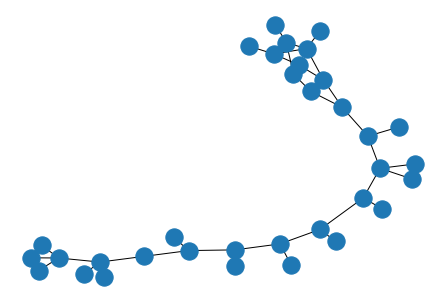

In [128]:
nx.draw(predicted_graphs_x[32], cmap = plt.get_cmap('jet'))
plt.show()